In [30]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [31]:
# Image directories
train_dir = "images/images/training/"
test_dir = "images/images/test/"

In [32]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [33]:
# Load training data
train_img = load_dataset(train_dir)

In [34]:
import numpy as np

# Ensure train_img is not empty
if len(train_img) > 0:
    # Pick a random index
    pick_random = np.random.randint(0, len(train_img))

    # Check image size
    print(f'Image {pick_random}')
    print(train_img[pick_random][0].shape)



Image 215
(469, 640, 3)


In [35]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')
    

Shape	: (591, 800, 3)
Label	: images\images\training\night


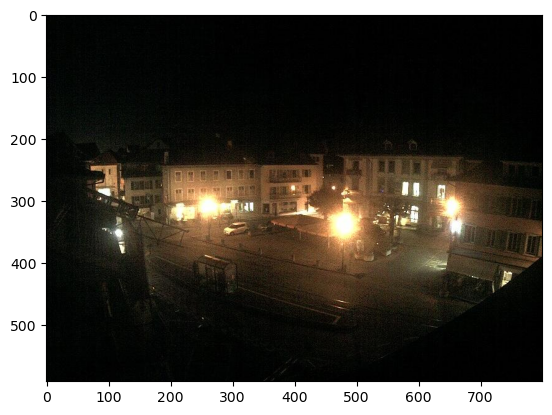

In [36]:
random_img_viz(train_img)

Langkah 3 - Pra Pengolahan Data

In [37]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

In [38]:
def label_encoder(label):
    # Extract the label by splitting the path and taking the last part
    label = label.split('\\')[-1].strip().lower()  # for Windows-style paths
    num_val = 0
    if label == 'day':
        num_val = 1

    return num_val

In [39]:
def preprocess(img_list):
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    
    return std_img_list

In [40]:
#Lakukan pra pengolahan data pada data training.
train_std_img_list = preprocess(train_img)

In [41]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 31
(600, 1100, 3)


Shape	: (600, 1100, 3)
Label	: 0


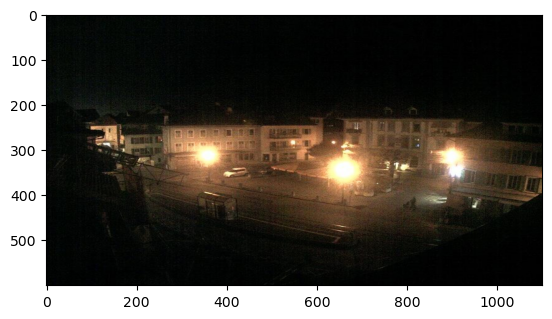

In [42]:
random_img_viz(train_std_img_list)

In [43]:
#Langkah 4 - Ekstraksi Fitur

# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

Image 220
Avg Brighness: 88.3847


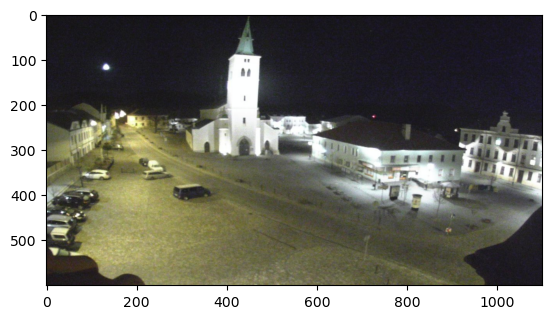

In [44]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

In [45]:
#Langkah 5 - Klasifikasi dengan Metode Threshold

def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1
    
    return pred

Image 232
Actual label: 0
Predicted label: 0


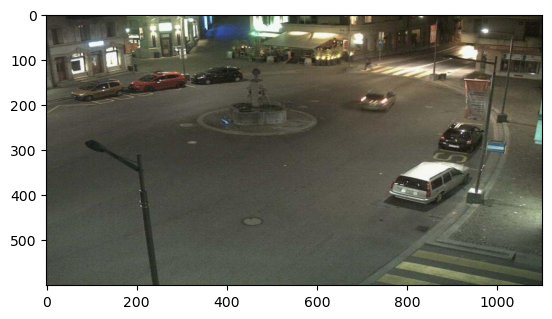

In [46]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

In [47]:
#Langkah 6 - Evaluasi (Manual

def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')

In [48]:
# Evaluate on train data
evaluate(train_std_img_list, threshold=120)

Accuracy: 0.8417


In [49]:
# Evaluate on test data

# Load test data
test_img = load_dataset(test_dir)

# Preprocess
test_std_img_list = preprocess(test_img)

# Predict
evaluate(test_std_img_list, threshold=120)

Accuracy: 0.8688


In [50]:
#Langkah 4 alternatif - Membuat Feature Vectors

# Create function to extract feature for every images and stored in tabular data
# Stored in Pandas dataframe
def extract_avg_bright_feature(img_list):
    avg_list = []
    labels = []

    for img in img_list:
        img_avg = avg_brightness(img[0]) # Get the avg brightness from image
        img_label = img[1] # Get the image label

        avg_list.append(img_avg)
        labels.append(img_label)
    
    # Stack data in columcular way
    data = np.column_stack((avg_list, labels))
    # Create a Pandas dataframe
    df = pd.DataFrame(data, columns=['AVG_BRIGHT', 'LABELS'])

    return df

In [51]:
# Extract feature on train data
train_avg_img = extract_avg_bright_feature(train_std_img_list)
print(f'Shape: {train_avg_img.shape}')
train_avg_img.head()

Shape: (240, 2)


,AVG_BRIGHT,LABELS
0,175.092992,1.0
1,192.907867,1.0
2,132.133823,1.0
3,199.749191,1.0
4,109.947203,1.0


In [52]:
# Do the same thing on test data
test_avg_img = extract_avg_bright_feature(test_std_img_list)
print(f'Shape: {test_avg_img.shape}')
test_avg_img.head()

Shape: (160, 2)


,AVG_BRIGHT,LABELS
0,194.228062,1.0
1,157.826662,1.0
2,201.607444,1.0
3,191.237441,1.0
4,188.119652,1.0


In [53]:
#Langkah 5 alternatif

# import requied library
from sklearn.svm import SVC

# Split data and label
X_train = train_avg_img.iloc[:,0].values.reshape(-1,1)
y_train = train_avg_img.iloc[:,1]
X_test = test_avg_img.iloc[:,0].values.reshape(-1,1)
y_test = test_avg_img.iloc[:,1]

model = SVC()
model.fit(X_train, y_train)



SVC()

Langkah 6 alternatif

In [54]:
from sklearn.metrics import accuracy_score

# Make a prediction on train data
y_train_pred = model.predict(X_train)

# Get the accuracy on train data
acc_train = accuracy_score(y_train, y_train_pred)

# Make a prediction on test data
y_test_pred = model.predict(X_test)

# Get the accuracy on test data
acc_test = accuracy_score(y_test, y_test_pred)

# Print Eval Result
print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.8583333333333333
Accuracy on test: 0.9
